### Matheus Prola Pfitscher
### Martin Jungblut Schreiner

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Primeiro exercício

jogadores = pd.read_excel("JOGADORES_NBA.xlsx")
metricas_nba = pd.read_excel("METRICAS_NBA.xlsx")

In [3]:
# useful functions, keep them all here

def quantile_replacement(dataset, identifier, lower, upper, method):
    dataset = dataset.copy(deep=True)
    
    lower_quantile = dataset[identifier].quantile(lower)
    upper_quantile = dataset[identifier].quantile(upper)

    filter_matrix = (dataset[identifier] < upper_quantile) & (dataset[identifier] > lower_quantile)

    try:
        replacement = getattr(dataset[filter_matrix][identifier], method)()
    except AttributeError:
        raise ValueError("Invalid method: {}".format(method))

    dataset.loc[np.invert(filter_matrix), identifier] = replacement
    return dataset

In [4]:
# data pre-processing

dataset = jogadores.merge(metricas_nba, on=("Player"))

for extremised_feature in ("height", "weight", "TS%", "FTr"):
    dataset = quantile_replacement(dataset, extremised_feature, 0.003, 0.997, method="mean")
    print(extremised_feature, dataset[extremised_feature].min(),
          dataset[extremised_feature].max(), dataset[extremised_feature].mean())

for missing_data_feature in ("birth_city", "birth_state", "collage"):
    dataset.loc[dataset[missing_data_feature].isnull(), missing_data_feature] = "N/A"
    print("Set {} missing entries from column '{}' as N/A.".format(
        len(dataset[dataset[missing_data_feature] == "N/A"]), missing_data_feature
    ))

dataset["AgeDisc"] = pd.qcut(dataset["Age"], q=3, labels=["Junior", "Middle", "Senior"])

height 173.0 226.0 199.43174187208254
weight 63.0 133.0 95.45299145299145
TS% 0.046 0.85 0.4956298891315996
FTr 0.01 1083.0 1.4394350268170109
Set 1646 missing entries from column 'birth_city' as N/A.
Set 1689 missing entries from column 'birth_state' as N/A.
Set 2223 missing entries from column 'collage' as N/A.


In [5]:
# Qual a média de idade/peso dos jogadores?

df_mean = dataset.mean()
print("Age: {}".format(df_mean["Age"]))
print("Weight: {}".format(df_mean["weight"]))

Age: 26.66440526486838
Weight: 95.45299145299145


In [6]:
# Qual a média de idade/peso dos jogadores na década de 50? Compare com a década de 90.

df_50 = dataset[dataset['Year'].between(1950, 1960)].mean()
df_90 = dataset[dataset['Year'].between(1990, 2000)].mean()
print("50's")
print("Age: {}".format(df_50["Age"]))
print("Height: {}".format(df_50["height"]))
print("Weight: {}".format(df_50["weight"]))
print("-------")
print("90's")
print("Age: {}".format(df_90["Age"]))
print("Height: {}".format(df_90["height"]))
print("Weight: {}".format(df_90["weight"]))
print("-------")

50's
Age: 26.055805003207183
Height: 193.94511805998724
Weight: 88.87838921342431
-------
90's
Age: 27.22980218154927
Height: 200.1523456592628
Weight: 95.83808404163369
-------


In [7]:
# Qual o jogador que mais marcou pontos na série histórica (desconsiderando ano/time)?

players_sum = dataset.groupby("Player").sum()
players_sum["PTS"].sort_values(ascending=False)

Player
Kareem Abdul-Jabbar*        38387
Karl Malone*                36928
Wilt Chamberlain*           33953
Kobe Bryant                 33643
Michael Jordan*             32292
                            ...  
Al Jackson                      0
Tom Hovasse                     0
Martynas Andriuskevicius        0
Mike Champion                   0
Maurice Baker                   0
Name: PTS, Length: 3921, dtype: int64

In [8]:
# Qual foi primeiro jogador a atingir a marca de 2 mil pontos em um único time? Em que ano isso aconteceu?

df_cumsum = dataset.groupby(["Player", "Tm", "Year"]).sum().groupby(level=[0, 1]).cumsum()
df_cumsum.reset_index(inplace=True)
df_cumsum[df_cumsum["PTS"] >= 2000].sort_values(by="Year", ascending=True)[["Player", "Tm", "Year", "PTS"]]

,Player,Tm,Year,PTS
456,Alex Groza,INO,1951,2925
6780,Dolph Schayes*,SYR,1951,2193
8957,George Mikan*,MNL,1951,3797
18956,Ralph Beard,INO,1951,2006
12170,Joe Fulks*,PHW,1951,2201
...,...,...,...,...
16600,Metta World,LAL,2017,3197
1047,Anthony Davis,NOP,2017,6630
13888,Kentavious Caldwell-Pope,DET,2017,3665
24236,Will Barton,DEN,2017,2305


In [9]:
# Qual jogador que jogou por mais tempo na NBA?

dataset.groupby("Player").count()["Year"].sort_values(ascending=False)

Player
Eddie Johnson       33
Mike Dunleavy       32
Gerald Henderson    29
Nazr Mohammed       28
Kevin Willis        27
                    ..
Gundars Vetra        1
Guy Morgan           1
Guy Rucker           1
Hal Lear             1
Joby Wright          1
Name: Year, Length: 3921, dtype: int64

In [10]:
# Qual jogador permaneceu mais tempo em um mesmo time? Qual é este time? Por quanto tempo ele ficou neste time?

dataset.groupby(["Player", "Tm"]).count()["Year"].sort_values(ascending=False)

Player          Tm 
Kobe Bryant     LAL    20
Tim Duncan      SAS    19
John Stockton*  UTA    19
Dirk Nowitzki   DAL    19
Karl Malone*    UTA    18
                       ..
Kevin Stacom    IND     1
                MIL     1
                TOT     1
Kevin Thompson  POR     1
Joe Reaves      PHO     1
Name: Year, Length: 12150, dtype: int64

In [11]:
# Segundo exercício

# etapa 1
df = pd.read_csv("CAFE_DA_MANHA.csv")

In [12]:
# etapa 2 a
df["Qtd"] = 1 

In [13]:
# etapa 2 b
pivot_df = df.pivot_table(columns = ["Item"], index = ["Date", "Time", "Transaction"], values = "Qtd", fill_value = 0, aggfunc=np.sum)

In [14]:
# etapa 3
corr_df = pivot_df.corr()

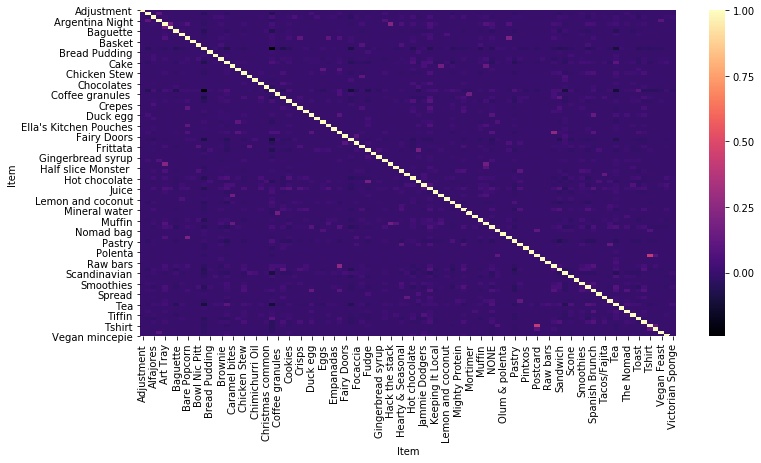

In [15]:
# etapa 4
plt.figure(figsize=[12, 6])
sns.heatmap(corr_df, cmap="magma")